In [40]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BIC, BDeu, BayesianEstimator, LogLikelihoodGauss
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
import json
import pandas as pd


In [18]:
# Use keyword heuristics to define latent variables (instead of LDA)

PRICE_KEYWORDS = {"expensive", "pricey", "affordable", "overpriced", "prices"}
FOOD_KEYWORDS = {"food", "dish", "meal", "taste", "flavor", "portion", "menu", "delicious"}
SERVICE_KEYWORDS = {"waiter", "waitress", "staff", "rude", "slow", "friendly", "host", "service"}
CLEANLINESS_KEYWORDS = {"clean", "dirty", "bathroom", "restroom", "table", "floor", "smell"}

def contains_keywords(text, keyword_set, min_hits=2):
    # returns True if text contains enough words within keyword_set
    text_lower = text.lower()
    return sum(1 for kw in keyword_set if kw in text_lower) >= min_hits

def extract_features(review_json):
    # preps review for panda dataframe
    text = review_json["text"]
    return {
        "price_mentioned": "yes" if contains_keywords(text, PRICE_KEYWORDS) else "no",
        "food_mentioned": "yes" if contains_keywords(text, FOOD_KEYWORDS) else "no",
        "service_mentioned": "yes" if contains_keywords(text, SERVICE_KEYWORDS) else "no",
        "cleanliness_mentioned": "yes" if contains_keywords(text, CLEANLINESS_KEYWORDS) else "no",
        "star_rating": float(review_json["stars"])
    }

def get_business_id(business_name, business_json_path="data/yelp_academic_dataset_business.json"):
    # Retrieves serial business ID and returns it
    with open(business_json_path, "r", encoding="utf-8") as f:
        for line in f:
            biz = json.loads(line)
            if biz["name"].lower() == business_name.lower():
                return biz["business_id"]
    raise ValueError(f"Business '{business_name}' not found in dataset.")

def load_reviews_df(business_name, reviews_path="sample_reviews.json", business_path="data/yelp_academic_dataset_business.json"):
    # Extracts all relevant reviews from business name parameter and consolidates it all into a panda dataframe
    business_id = get_business_id(business_name, business_path)

    reviews = []
    with open(reviews_path, "r", encoding="utf-8") as f:
        for line in f:
            review = json.loads(line)
            if review["business_id"] == business_id:
                reviews.append(extract_features(review))

    return pd.DataFrame(reviews)

def display_sample():
    with open("sample_reviews.json", "r", encoding="utf-8") as f:
        reviews = [json.loads(line) for line in f]  # fallback for line-delimited

    sample_biz_ids = {r["business_id"] for r in reviews}
    found_names = []

    with open("data/yelp_academic_dataset_business.json", "r", encoding="utf-8") as f:
        for line in f:
            biz = json.loads(line)
            if biz["business_id"] in sample_biz_ids:
                found_names.append((biz["name"], biz["city"], biz["state"]))

    for name, city, state in sorted(found_names):
        print(f"- {name} — {city}, {state}")


#display_sample()   
# Use load_reviews to create pandas dataframe for model training.
df = load_reviews_df("In-N-Out Burger", "data/yelp_academic_dataset_review.json")
print(df.head())
print(f"Parsed {len(df)} reviews for this business.")
print(df.shape)

  price_mentioned food_mentioned service_mentioned cleanliness_mentioned  \
0              no             no                no                    no   
1              no             no                no                    no   
2              no            yes                no                    no   
3              no             no               yes                   yes   
4              no             no                no                    no   

   star_rating  
0          5.0  
1          5.0  
2          5.0  
3          5.0  
4          4.0  
Parsed 230 reviews for this business.
(230, 5)


Lets create a structure for our model and fit the data. From here we can create an inference from pgmpy to create queries to find out which aspects have the most impact.

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'price_mentioned': 'C', 'food_mentioned': 'C', 'service_mentioned': 'C', 'cleanliness_mentioned': 'C', 'star_rating': 'N', 'predicted_rating': 'N'}


food_mentioned: delta = 0.008
service_mentioned: delta = -0.097
cleanliness_mentioned: delta = 0.018
price_mentioned: delta = 0.000


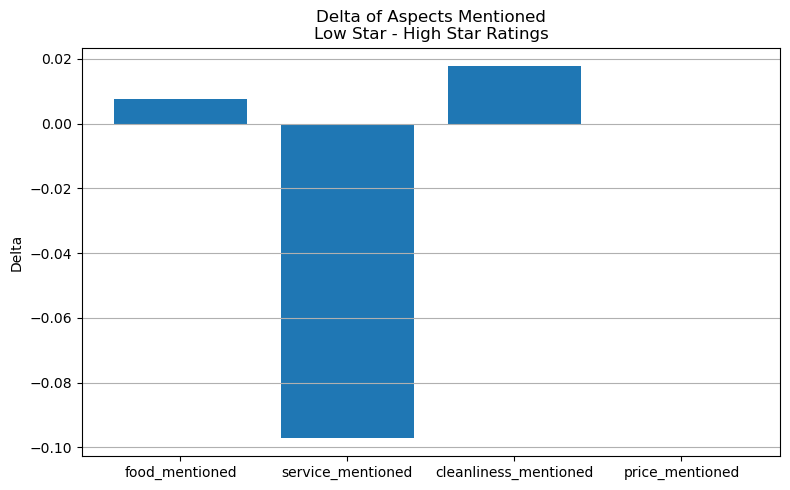

In [ ]:
# Use Bayes-Net model to determine variable with highest delta (makes the difference for review)
aspects = ["food_mentioned", "service_mentioned", "cleanliness_mentioned", "price_mentioned"]
low_ratings = {1.0, 2.0, 3.0} # all 5-star scores that represent a "negative review"
high_ratings = {4.0, 5.0} # good reviews

model = DiscreteBayesianNetwork([
    ("food_mentioned", "star_rating"),
    ("service_mentioned", "star_rating"),
    ("cleanliness_mentioned", "star_rating"),
    ("price_mentioned", "star_rating")
])

model.fit(df, estimator=BayesianEstimator, prior_type="BDeu")

# Run inference queries
inference = VariableElimination(model)

def get_yes_prob(var, rating:float):
    query = inference.query(variables=[var], evidence={"star_rating": rating})
    try:
        yes_index = query.state_names[var].index("yes")
        return query.values[yes_index]
    except ValueError:
        # this means "yes" isn't in this dist.
        return 0.0
    

# Average over group of ratings
def get_group_prob(var, rating_group):
    probs = [get_yes_prob(var, r) for r in rating_group]
    return sum(probs) / len(probs)

# P(mention=yes | low) - P(mention=yes | high)
delta_results = {}

for var in aspects:
    low_avg = get_group_prob(var, low_ratings)
    high_avg = get_group_prob(var, high_ratings)
    delta = low_avg - high_avg
    delta_results[var] = delta

# Plot Deltas
plt.figure(figsize=(8, 5))
aspect_names = list(delta_results.keys())
delta_values = list(delta_results.values())

plt.bar(aspect_names, delta_values)
plt.ylabel("Delta")
plt.title("Delta of Aspects Mentioned\nLow Star - High Star Ratings")
plt.tight_layout()
plt.grid(axis='y')

# Show the plot
plt.show()


We'll be using our trained Bayes Net to predict the most likely star_rating for each review based on our four defined features. This will help us evaluate if the model is able to recover any relevant/accurate user sentiment from text.

In [35]:
# Prediction Accuracy

def predict_star(row):
    evidence = {col: row[col] for col in ["food_mentioned", "service_mentioned", "cleanliness_mentioned", "price_mentioned"]}
    result = inference.map_query(variables=["star_rating"], evidence=evidence, show_progress=False)
    return result["star_rating"]

df["predicted_rating"] = df.apply(predict_star, axis=1)
accuracy = accuracy_score(df["star_rating"], df["predicted_rating"])
print(f"Prediction Accuracy: {accuracy:.3f}")

Prediction Accuracy: 0.509


Using MAP inference we were able to predict star ratings with a 51% accuracy.

{'food_mentioned': 0.0001564926062945695, 'service_mentioned': 0.038482729327863174, 'cleanliness_mentioned': 0.0033236887831593932, 'price_mentioned': 0.0}


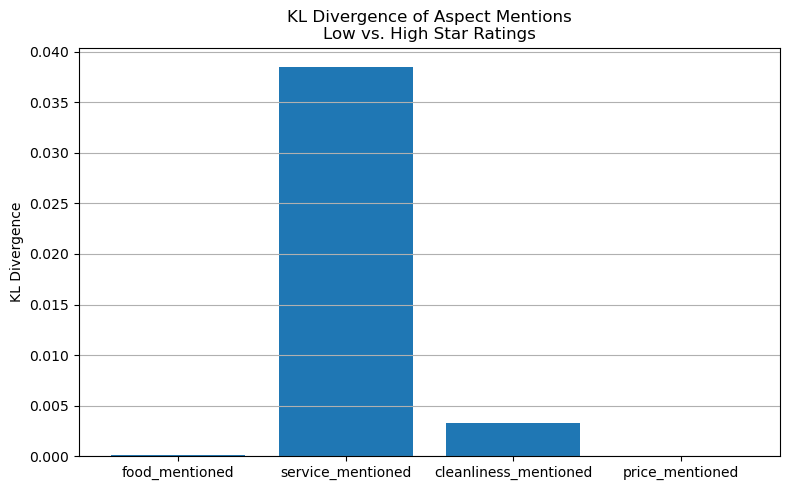

In [41]:
# KL Divergence
 
kl_divergences = {}

def get_distribution(var, rating_group):
    dists = []
    for r in rating_group:
        result = inference.query(variables=[var], evidence={"star_rating": float(r)})
        dists.append(result.values)
    return np.mean(dists, axis=0)

for var in ["food_mentioned", "service_mentioned", "cleanliness_mentioned", "price_mentioned"]:
    p_low = get_distribution(var, low_ratings)
    p_high = get_distribution(var, high_ratings)
    kl = entropy(p_low, p_high)
    kl_divergences[var] = kl

print(kl_divergences)

# Plot KL Divergence
plt.figure(figsize=(8, 5))
aspect_names = list(kl_divergences.keys())
kl_values = list(kl_divergences.values())

plt.bar(aspect_names, kl_values)
plt.ylabel("KL Divergence")
plt.title("KL Divergence of Aspect Mentions\nLow vs. High Star Ratings")
plt.tight_layout()
plt.grid(axis='y')

# Show the plot
plt.show()